# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/data/joint_scoring/labels_test_regression.h5', 'r') as hf:
    y = hf['labels_test_regression'][:]
    
with h5py.File('/data/joint_scoring/img_test_regression.h5', 'r') as hf:
    imgs = hf['img_test_regression'][:]

imgs = imgs
y = y

y.shape, imgs.shape

((19709,), (19709, 150, 150, 1))

In [3]:
from tensorflow.python.keras import backend as K

def crps(y_true, y_pred):
    diff = (y_true - y_pred)
    diff_2 = K.square(diff)
    loss = K.mean(diff_2)
    return loss

In [5]:
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/data/joint_scoring/models/20171104_135018.h5", custom_objects={"crps":crps})

In [6]:
p = loaded_model.predict(imgs)

In [7]:
pred = np.zeros(p.shape[0])

for i in range(p.shape[0]):
    pred[i] = sum(1 - p[i])

In [8]:
diff = pred - y

In [9]:
diff

array([ 0.92763996,  0.48160774,  0.4225744 , ...,  0.78341782,
        0.22367388,  4.32695609])

## Build truncated model

In [10]:
config = loaded_model.get_config()

In [11]:
config = config[0:48]

In [12]:
model = Sequential.from_config(config)

In [13]:
weights = loaded_model.get_weights()

In [14]:
model.set_weights(weights)

## Get embeddings

In [15]:
embeddings = model.predict(imgs)

In [16]:
from sklearn.decomposition import PCA
x_50d = PCA(n_components=50).fit_transform(embeddings)

In [17]:
from sklearn.manifold import TSNE
x_2d = TSNE(n_components=2, random_state=1).fit_transform(x_50d)

In [38]:
np.savetxt("/data/joint_scoring/tsne/x_2d_regression.csv", x_2d, delimiter=";")
np.savetxt("/data/joint_scoring/tsne/y_regression.csv", y, delimiter=";")

In [39]:
with h5py.File('/data/joint_scoring/patients_test_regression.h5', 'r') as hf:
    patients = hf['patients_test_regression'][:]
np.savetxt("/data/joint_scoring/tsne/patients_regression.csv", y, delimiter=";")

## 2D

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_regression.png', bbox_inches='tight')

In [18]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=diff, cmap=plt.cm.get_cmap("RdBu"))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_diference_regression.png', bbox_inches='tight')

## KNN

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [41]:
cv_scores = []

for k in range(1,10,2):
    print(k)
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, embeddings, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

1
3
5
7
9


In [42]:
mse = [-1 * x for x in cv_scores]
mse

[140.36596844602064,
 97.793633397747328,
 86.84767124626886,
 83.422100771452307,
 81.63237536877314]

The optimal number of neighbors is 9


<IPython.core.display.Javascript object>


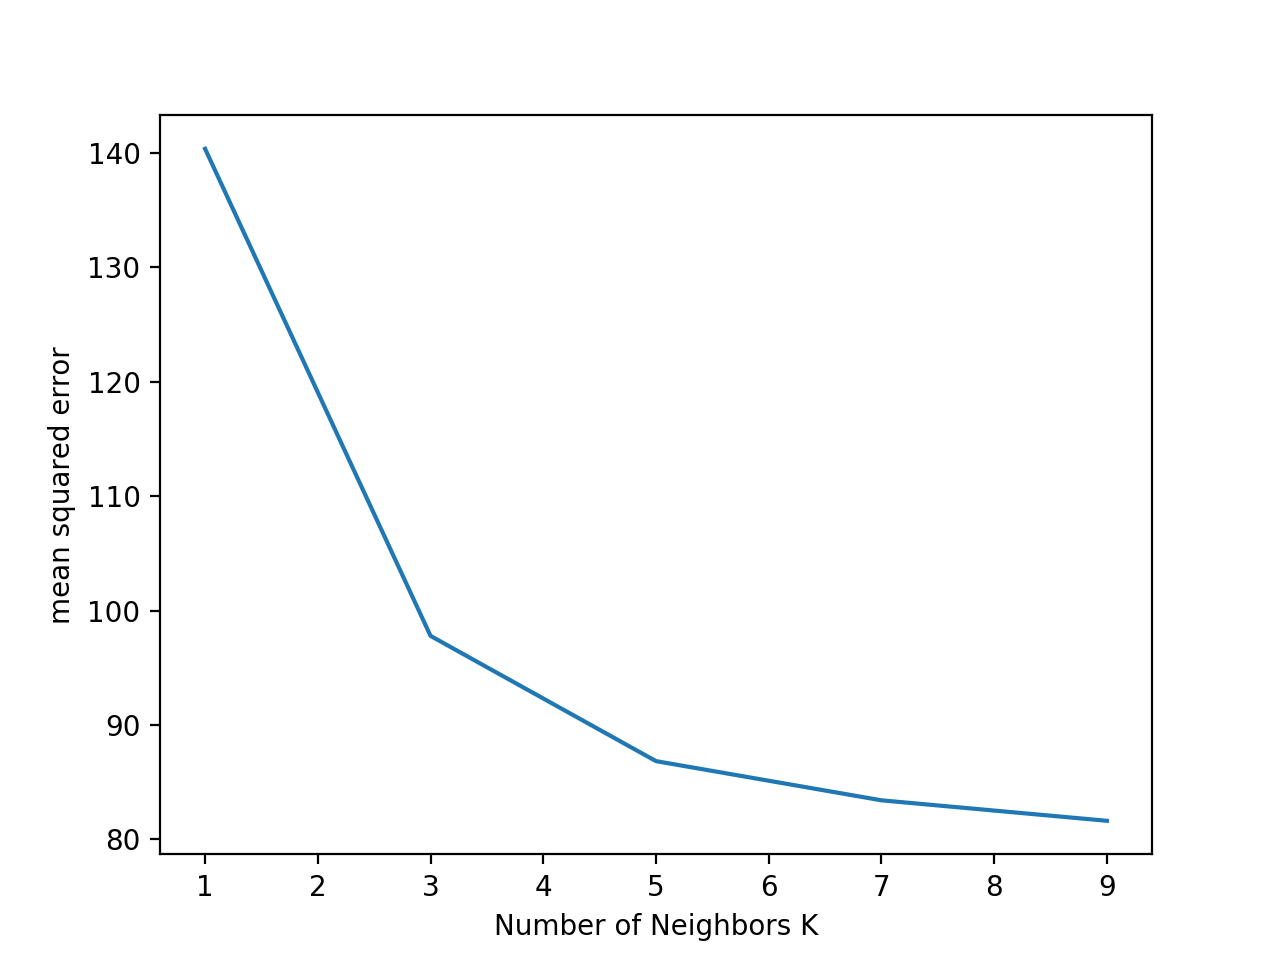

In [44]:
# determining best k
optimal_k = range(1,10,2)[mse.index(min(mse))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.close()
plt.plot(range(1,10,2), mse)
plt.xlabel('Number of Neighbors K')
plt.ylabel('mean squared error')
plt.show()

## 3D

In [19]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, random_state=1).fit_transform(x_50d)

In [20]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis"))
plt.savefig('/data/joint_scoring/images/tsne_3d_regression.png', bbox_inches='tight')

In [21]:
!pip3 install scikit-image --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(50, 50)) for x in imgs]
imgs_resized = np.array(imgs_resized)

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: matplotlib>=1.3.1 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: PyWavelets>=0.4.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: six>=1.7.3 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pillow>=2.1.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: scipy>=0.17.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: networkx>=1.8 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: numpy>=1.7.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1.3.1->scikit-image)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
n_colors = len(np.unique(y.astype("int16")))

In [23]:
cm = plt.cm.get_cmap("viridis", n_colors)
color = np.ones((n_colors, 4))
for i in range(n_colors):
    color[i] = cm(1.*i/n_colors)

color = [np.append((x[0:-1] * 255),1) for x in color]
color = np.array(color)


color = color.astype("int16")

print(color)
print(type(color[0]))

[[ 68   1  84   1]
 [ 71  18 101   1]
 [ 72  34 115   1]
 [ 70  49 126   1]
 [ 66  64 133   1]
 [ 60  77 138   1]
 [ 54  91 140   1]
 [ 48 103 141   1]
 [ 43 115 142   1]
 [ 39 126 142   1]
 [ 34 137 141   1]
 [ 31 150 139   1]
 [ 31 161 135   1]
 [ 38 172 129   1]
 [ 53 183 120   1]
 [ 53 183 120   1]
 [100 203  93   1]
 [129 211  76   1]
 [159 217  56   1]
 [191 223  36   1]
 [223 227  24   1]
 [253 231  36   1]]
<class 'numpy.ndarray'>


In [33]:
y_unique = np.unique(y.astype("int16"))
y_unique = y_unique.tolist()
print(y_unique)
y_index = y_unique.index(50)
print(y_index)

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 58, 60, 65, 70, 75, 80, 85, 90, 95, 100]
10


In [34]:
from PIL import Image
from PIL import ImageMath
from IPython.display import clear_output

imgs_border = []

old_size = (50, 50)
new_size = (54, 54)

y_unique = np.unique(y.astype("int16"))
y_unique = y_unique.tolist()

for i, img in enumerate(imgs_resized):
    if i % 100 == 0:
        clear_output()
        print("Creating images with colored borders, {0:.2f} % finished".format(i/19611*100))
    old_im = Image.fromarray((img.squeeze()*255).astype("int16"))
    old_im = old_im.convert("RGB")
    y_index = y_unique.index(y[i])
    new_im = Image.new("RGB", new_size, tuple(color[int(y_index)]))
    new_im.paste(old_im, (2,2))
    dat = np.asarray(a=new_im)
    imgs_border.append(dat)

Creating images with colored borders, 100.45 % finished


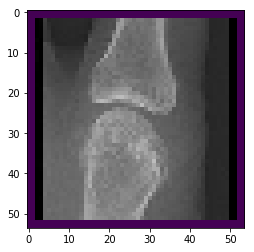

In [39]:
plt.imshow(imgs_border[0])
plt.show()

In [40]:

res = 8000 # resolution of plot
cval = 255 # background colour

images = imgs_border
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [41]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [42]:
res_x, res_y

(8000, 8377.4373466625111)

In [43]:
res_y=res_y.astype("int16")

In [44]:
images[0].shape

(54, 54, 3)

In [45]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611*100))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

In [46]:
plt.figure(figsize=(400,400))
plt.imshow(canvas)
plt.savefig('/data/joint_scoring/images/embeddings_regression.png', bbox_inches='tight')